<a href="https://colab.research.google.com/github/selimunal/Pytorch/blob/main/PyTorch_CNN_FachionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
train_dataset=torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.targets.shape

torch.Size([60000])

In [ ]:
test_dataset=torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [ ]:
test_dataset.targets.shape

torch.Size([10000])

In [ ]:
test_dataset.targets.max()

tensor(9)

In [ ]:
#number of classes
K=len(set(train_dataset.targets.numpy()))
print('number of classes:',K)

number of classes: 10


In [ ]:
#Define the model
class CNN(nn.Module):
  def __init__(self,K):
    super(CNN,self).__init__()
    self.conv_layers=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2)
    )

    self.dense_layers=nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128*2*2,512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512,K)
    )

  def forward(self,X):
    out=self.conv_layers(X)
    out=out.view(out.size(0),-1)
    out=self.dense_layers(out)
    return out


In [ ]:
model=CNN(K)

In [ ]:
#The same model Using the newly introduced 'flatten' format
# model=nn.Sequential(
#     nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128*2*2,512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512,K)
# )

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
#Loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [ ]:
#Data Loader
#Useful because it automatically generates batches in the training loop
#and takes care of shuffling
batch_size=99
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

In [ ]:
#A function to encapsulate the training loop
def batch_gd(model,criterion,optimizer,train_loader,test_loader,epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0=datetime.now()
    train_loss=[]
    for inputs,targets in train_loader:
      #move data to GPU
      inputs,targets=inputs.to(device),targets.to(device)

      #zero the parameter gradients
      optimizer.zero_grad()

      #forward pass
      outputs=model(inputs)
      loss=criterion(outputs,targets)

      #backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    #get train loss and test loss
    train_loss=np.mean(train_loss) #little misleading

    model.eval()
    test_loss=[]
    for inputs,targets in test_loader:
      inputs,targets=inputs.to(device),targets.to(device)
      outputs=model(inputs)
      loss=criterion(outputs,targets)
      test_loss.append(loss.item())
    test_loss=np.mean(test_loss)

    #save losses
    train_losses[it]=train_loss
    test_losses[it]=test_loss

    dt=datetime.now()-t0

    print(f'Epoch {it+1}/{epochs},Train Loss: {train_loss:.4f},Test Loss: {test_loss:.4f} ,\
    Duration: {dt}')

  return train_losses,test_losses

In [ ]:
train_losses, test_losses=batch_gd(model,criterion,optimizer,train_loader,test_loader, epochs=1)

Epoch 1/15,Train Loss: 0.5937,Test Loss: 0.4575 ,    Duration: 0:00:27.889608
Epoch 2/15,Train Loss: 0.4035,Test Loss: 0.3752 ,    Duration: 0:00:26.064111
Epoch 3/15,Train Loss: 0.3497,Test Loss: 0.3470 ,    Duration: 0:00:27.034675
Epoch 4/15,Train Loss: 0.3160,Test Loss: 0.3330 ,    Duration: 0:00:26.207314
Epoch 5/15,Train Loss: 0.2862,Test Loss: 0.3197 ,    Duration: 0:00:25.982047
Epoch 6/15,Train Loss: 0.2655,Test Loss: 0.3255 ,    Duration: 0:00:26.216457
Epoch 7/15,Train Loss: 0.2486,Test Loss: 0.2997 ,    Duration: 0:00:26.390667
Epoch 8/15,Train Loss: 0.2336,Test Loss: 0.2973 ,    Duration: 0:00:27.131867


KeyboardInterrupt: ignored

In [ ]:
inputs,targets=next(iter(train_loader))
inputs.shape

torch.Size([99, 1, 28, 28])

In [ ]:
targets.shape

torch.Size([99])

In [ ]:
      outputs=model(inputs)
      loss=criterion(outputs,targets)


In [ ]:
outputs.shape

torch.Size([99, 10])

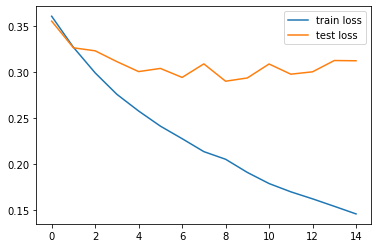

In [ ]:
#plot the train and test loss per iteration
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()
plt.show()

In [ ]:
#accuracy
model.eval()
n_correct=0.
n_total=0.
for inputs,targets in train_loader:
  #move the data to GPU
  inputs,targets=inputs.to(device),targets.to(device)

  #forward pass
  outputs=model(inputs)

  #get prediction
  #torch.max returns bath max and argmax
  _,predictions=torch.max(outputs,1)

  #update counts
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]

train_acc=n_correct/n_total


n_correct=0.
n_total=0.
for inputs,targets in test_loader:
  #move the data to GPU
  inputs,targets=inputs.to(device),targets.to(device)

  #forward pass
  outputs=model(inputs)

  #get prediction
  #torch.max returns bath max and argmax
  _,predictions=torch.max(outputs,1)

  #update counts
  n_correct += (predictions==targets).sum().item()
  n_total += targets.shape[0]

test_acc=n_correct/n_total

print(f'Train acc: {train_acc:.4f},Test acc:{test_acc:.4f}')

Train acc: 0.9626,Test acc:0.9013


In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Do these results make sense?
# It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc. 

Confusion matrix, without normalization
[[860   0  27  11   1   1  96   0   4   0]
 [  6 971   2  13   3   0   4   0   1   0]
 [ 14   0 892   8  24   0  61   0   1   0]
 [ 11   4  18 907  27   0  31   0   1   1]
 [  3   0 100  29 764   0 103   0   1   0]
 [  0   0   0   1   0 975   0  17   1   6]
 [ 98   0  61  17  58   0 760   0   6   0]
 [  0   0   0   0   0  19   0 949   0  32]
 [  2   0   6   1   2   1  10   3 973   2]
 [  1   0   0   0   0   9   0  27   1 962]]


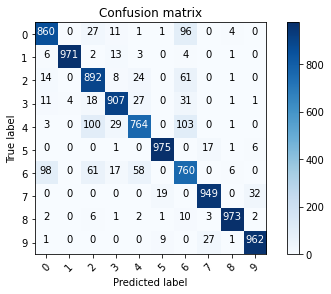

In [ ]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs,targets = inputs.784(device),targets.to(device)

  # reshape the input
  #inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
#label mapping
labels='''T shisort
trouser
pullover
dress
coat
sandal
shirt
sneaker
bag
anckle boot'''.split('\n')

In [ ]:
labels

['T shisort',
 'trouser',
 'pullover',
 'dress',
 'coat',
 'sandal',
 'shirt',
 'sneaker',
 'bag',
 'anckle boot']

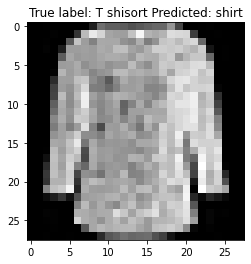

In [ ]:
# Show some misclassified examples
p_test=p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));